Generates a table for bursts over dist-hls val sites and adjacent.

In [9]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, shape
import contextily as cx
import asf_search as asf
from tqdm import tqdm
from rasterio.crs import CRS
import concurrent.futures

In [10]:
df_sites = gpd.read_file('../D_dist_sites/dist_hls_val_sites.geojson')
df_sites.head()

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,geometry
0,1,VLmaj,Natural browning,2021-10-08,NaT,22KCV,POINT (-52.37979 -23.29715)
1,2,noChange,No Change,NaT,NaT,52JEN,POINT (129.85033 -29.57724)
2,3,VLmin,Natural browning,2022-01-28,2022-01-06,14SNC,POINT (-98.60056 33.77100)
3,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,POINT (19.33289 4.57490)
4,5,VLmaj,Fire,2022-05-18,2022-05-11,50VMR,POINT (115.61901 63.10809)


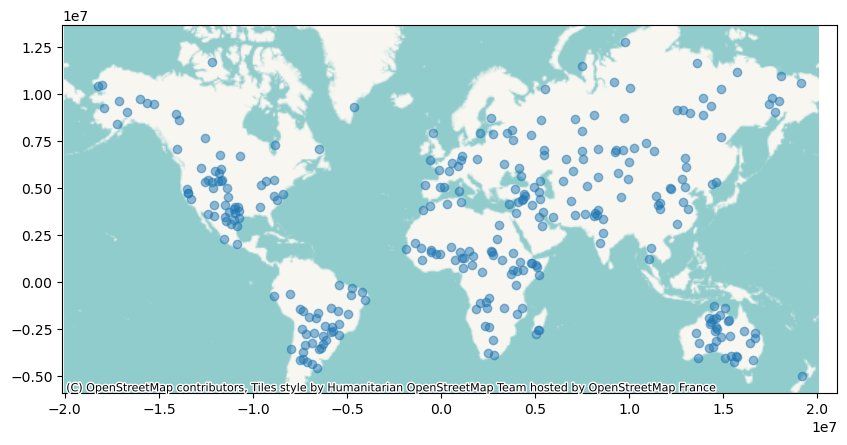

In [11]:
df_sites_wm = df_sites.to_crs(epsg=3857)
ax = df_sites_wm.plot(figsize=(10, 10), alpha=0.5)
cx.add_basemap(ax)

# Generate RTC Urls

In [4]:
response = asf.geo_search(intersectsWith=df_sites.geometry[30].wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, )
response

ASFSearchResults([<asf_search.Products.OPERAS1Product.OPERAS1Product at 0x16ebf4650>,
                  <asf_search.Products.OPERAS1Product.OPERAS1Product at 0x16ebf75f0>])

In [17]:
def get_resp_df(site_geo: Point)-> gpd.GeoDataFrame:
    resp = asf.geo_search(intersectsWith=site_geo.wkt,
                              processingLevel='RTC',
                              platform=asf.constants.SENTINEL1, )
    properties = [r.properties for r in resp]
    if properties:
        geometry = [shape(r.geojson()['geometry']) for r in resp]
        properties_f = [{'opera_id': p['sceneName'], 
                     'start_time': p['startTime'],
                     'polarization': p['polarization'],
                     'url_vh': p['url'], 
                     'url_vv': (p['url'].replace('_VH.tif', '_VV.tif')),
                     'track_number': p['pathNumber']} for p in properties]

        df = gpd.GeoDataFrame(properties_f, geometry=geometry, crs=CRS.from_epsg(4326))
        df = df.sort_values(by='start_time')
        df.drop(columns=['polarization'], inplace=True)
        df['acq_date'] = pd.to_datetime(df.start_time).dt.round('D').dt.date
    else:
        df = gpd.GeoDataFrame()
    return df

In [18]:
#dfs = list(map(get_resp_df, tqdm(df_sites.geometry.tolist())))
# with WorkerPool(n_jobs=5, use_dill=True) as pool:
#     dfs = pool.map(
#         get_resp_df,
#         df_sites.geometry.tolist(),
#         progress_bar=True,\
#         progress_bar_style="std",
#     )

import concurrent.futures
inputs = df_sites.geometry.tolist()
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    dfs = list(tqdm(executor.map(get_resp_df, inputs), total=len(inputs)))

100%|█| 300/300 [00:22<00:00, 13.36it/s]


In [19]:
df_all = pd.concat(dfs, axis=0)
df_all.head()

,opera_id,start_time,url_vh,url_vv,track_number,geometry,acq_date
201,OPERA_L2_RTC-S1_T107-227877-IW2_20150318T00354...,2015-03-18T00:35:43Z,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,107,"POLYGON ((-99.32096 33.55928, -98.28645 33.713...",2015-03-18
200,OPERA_L2_RTC-S1_T107-227877-IW2_20150821T00355...,2015-08-21T00:35:50Z,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,107,"POLYGON ((-99.32085 33.55932, -98.33524 33.706...",2015-08-21
199,OPERA_L2_RTC-S1_T107-227877-IW2_20160710T00355...,2016-07-10T00:35:55Z,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,107,"POLYGON ((-99.32052 33.56034, -98.34096 33.706...",2016-07-10
198,OPERA_L2_RTC-S1_T107-227877-IW2_20161014T00355...,2016-10-14T00:35:58Z,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,107,"POLYGON ((-99.32032 33.56018, -98.33776 33.706...",2016-10-14
197,OPERA_L2_RTC-S1_T107-227877-IW2_20161107T00355...,2016-11-07T00:35:58Z,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,107,"POLYGON ((-99.32140 33.55962, -98.33879 33.705...",2016-11-07


In [20]:
df_all.shape

(13998, 7)

<Axes: >

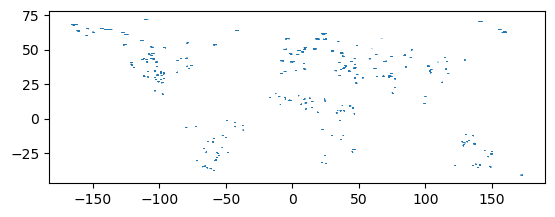

In [21]:
df_all.plot()

In [22]:
df_all.to_parquet('rtc_s1_data.parquet')